# **FINE TUNING WITH TWO LAYERS UNFREEZED**

In this paper we are going to perform the fine tuning by unfreezing the last two layers of our network.

## **Mount and unzipping**

At the beginning we allow the access to our Google Drive and then we unzip the dataset on our folder.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/MyDrive/progetto/dbs -all

total 16
drwx------ 2 root root 4096 Feb  7 21:28  dataset
drwx------ 2 root root 4096 Feb  6 16:30  facial_expression
drwx------ 2 root root 4096 Feb  5 22:16 'total_dbs(all images training one directory)'
drwx------ 2 root root 4096 Feb  5 22:12 'total_dbs_testing(all images public testing one directory)'


In [ ]:
pip install keras-facenet

     |████████████████████████████████| 2.3MB 8.4MB/s 
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-cp36-none-any.whl size=10386 sha256=c522aed8c7a6202e376eca174908818e8a551a416a12c20e79b7f1f44346fea2
  Stored in directory: /root/.cache/pip/wheels/f6/53/9a/36c4b52fd22faf4f710d5047d874655b85a1b2cf77accfb9bd
Successfully built keras-facenet


In [ ]:
'''
# Unzipping dataset
%cd '/content/gdrive/MyDrive/progetto/dbs/' 
!unzip -q original_facial_expression.zip
'''

"\n# Unzipping dataset\n%cd '/content/gdrive/MyDrive/progetto/dbs/' \n!unzip -q original_facial_expression.zip\n"

Now we import all the needed modules and we define the folders' path that we are going to use.

In [ ]:
import glob
import os
import numpy as np
import PIL
from PIL import ImageDraw, ImageOps, Image

import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras import applications
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import load_img

import matplotlib.pyplot as plt
from keras.models import load_model


from IPython.display import display
from tqdm.notebook import tqdm

import sklearn
from sklearn.preprocessing import Normalizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC, LinearSVC

np.random.seed(42)
tf.random.set_seed(42)


BASE_DIR = '/content/gdrive/MyDrive/progetto/dbs/facial_expression/dataset'
TRAIN_DATA_DIR = os.path.join(BASE_DIR, 'Training')
TEST_DATA_DIR = os.path.join(BASE_DIR, 'PublicTest')





BATCH_SIZE = 32

## **Dataset Loading** 

We use *image_dataset_from_directory()* provided by Keras to load the image dataset. At the end we perform the *prefetch()* function to improve the performance in dataset loading. Thanks to *prefectch()*, while model is executing the step *s* of the training, input pipeline read data for the step *s+1*. In this way the time needed is `max(training_time, time_to_read_data)` instead of `training_time + time_to_read_data`. 

In [ ]:


train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DATA_DIR,
    subset="training",
    validation_split=0.2,
    seed=123,
    image_size=(160, 160),
    batch_size=BATCH_SIZE,
    color_mode='rgb')

valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
   TRAIN_DATA_DIR,
   subset="validation",
   shuffle=False,
   validation_split=0.2,
   seed=123,
   image_size=(160, 160),
   batch_size=BATCH_SIZE,
   color_mode='rgb')

testing_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DATA_DIR,
    seed=123,
    shuffle=False,
    image_size=(160, 160),
    batch_size=BATCH_SIZE,
    color_mode='rgb')


train_dataset = train_dataset.prefetch(buffer_size=BATCH_SIZE)
valid_dataset = valid_dataset.prefetch(buffer_size=BATCH_SIZE)
testing_dataset = testing_dataset.prefetch(buffer_size=BATCH_SIZE)




Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 3589 files belonging to 7 classes.


## **Training**

Before to train our network, since our pretrained network doesn't belong to Keras, we are going to load the Inception ResNet v1 loading the weights and the model of the facenet keras respectively.


On the top of the pretrained network, we build our densly connected network. We have a *Flatten layer* that reshape the pretrained network's output and a dropout of 0.5 before the last layers. Then, we have two *Dense layers*: the first has 64 hidden layers with **ReLu** activation function while the last one has 7 layers (as the output class we have) with **softmax** activation function. Since we don't want to perform fine-tuning, hence we don't want to recompute the weights of the pretrained network, then we set the layer`trainable = False`.


In [ ]:


weights_path = '/content/gdrive/MyDrive/progetto/modello/keras-facenet/weights/facenet_keras_weights.h5'
top_model_weights_path = '/content/gdrive/MyDrive/progetto/modello/keras-facenet/model/facenet_keras.h5'

facenet = load_model(top_model_weights_path)
facenet.load_weights(weights_path)


for layer in facenet.layers:

    layer.trainable = False

model= Sequential()
model.add(facenet)
model.add(L.Flatten())

#dropout
model.add(L.Dropout(0.5))
model.add(L.Dense(64, activation='relu',name = 'classifier_hidden'))
model.add(L.Dense(7,activation = 'softmax'))


model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v1 (Functio (None, 128)               22808144  
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
classifier_hidden (Dense)    (None, 64)                8256      
_________________________________________________________________
dense (Dense)                (None, 7)                 455       
Total params: 22,816,855
Trainable params: 8,711
Non-trainable params: 22,808,144
_________________________________________________________________


Since we have many classes and an image belongs only to a specific class, we use the **sparse categorical crossentropy** as loss function. As optimizer, we use **RMSprop** with a very low **learning rate**. To avoid the problem of overfitting, we add also the **early stopping** whereby the training will stop when the chosen performance measure stops improving. To discover the training epoch on which training was stopped, the “verbose” argument can be set to 1. Once stopped, the callback will print the epoch number.

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])



callbacks = [
    # early stopping
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),

    # model checkpoints (save the best model)
    tf.keras.callbacks.ModelCheckpoint(
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        filepath='/content/gdrive/MyDrive/progetto/modello/keras-facenet/model/fine_tuning_2.h5'),
]

history = model.fit(
      train_dataset,
      epochs=50,
      verbose=1,
      callbacks=callbacks,
      validation_data=valid_dataset,
      batch_size=BATCH_SIZE)

Epoch 1/50
718/718 [==============================] - 8834s 12s/step - loss: 2.9047 - accuracy: 0.1521 - val_loss: 2.4837 - val_accuracy: 0.0209
Epoch 2/50
718/718 [==============================] - 59s 82ms/step - loss: 2.4202 - accuracy: 0.1800 - val_loss: 2.2226 - val_accuracy: 0.0449
Epoch 3/50
718/718 [==============================] - 63s 87ms/step - loss: 2.3162 - accuracy: 0.1805 - val_loss: 2.1295 - val_accuracy: 0.0627
Epoch 4/50
718/718 [==============================] - 65s 89ms/step - loss: 2.2273 - accuracy: 0.1936 - val_loss: 2.0711 - val_accuracy: 0.0766
Epoch 5/50
718/718 [==============================] - 64s 88ms/step - loss: 2.2023 - accuracy: 0.1859 - val_loss: 2.0324 - val_accuracy: 0.0949
Epoch 6/50
718/718 [==============================] - 64s 89ms/step - loss: 2.1332 - accuracy: 0.1999 - val_loss: 2.0190 - val_accuracy: 0.1014
Epoch 7/50
718/718 [==============================] - 63s 88ms/step - loss: 2.1034 - accuracy: 0.1941 - val_loss: 2.0106 - val_accuracy

# **Plot**

Now we plot the results obtained.

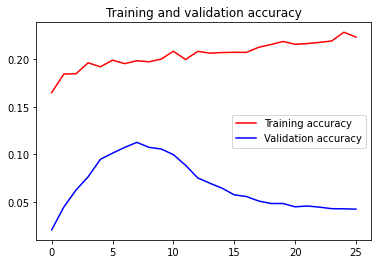

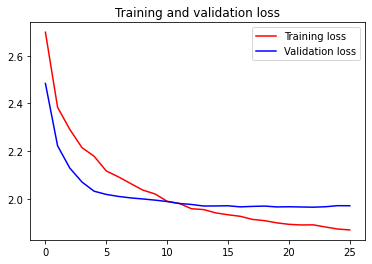

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## **Finetune the pretrained network**



We can try to improve these results by performing fine tuning. In particular, in this paper we try to fine tune the last two layers of the pretrained network by setting the layer 'Block8_5_Branch_1_Conv2d_0a_1x1' `trainable = True` 
Our densly connected network builds on the top of the pretrained network is the same we have seen before.

In [ ]:
#try to un-freeze the last 2 blocks

facenet.trainable = True


set_trainable = False
for layer in facenet.layers:
    if layer.name == 'Block8_5_Branch_1_Conv2d_0a_1x1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False



facenet.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

Since we have many classes and an image belongs only to a specific class, we use the **sparse categorical crossentropy** as loss function. We use as optimizer **RMSprop** with a **learning rate** of magnitude same as before and we use again the early stoppinh technique to avoid the overfitting seen previously.

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

In [ ]:
fine_history = model.fit(
      train_dataset,
      epochs=50,
      validation_data=valid_dataset,
      callbacks = callbacks,
      batch_size = BATCH_SIZE
      )

Epoch 1/50
718/718 [==============================] - 65s 82ms/step - loss: 2.2328 - accuracy: 0.2170 - val_loss: 1.7447 - val_accuracy: 0.2695
Epoch 2/50
718/718 [==============================] - 62s 86ms/step - loss: 2.0418 - accuracy: 0.2392 - val_loss: 1.7293 - val_accuracy: 0.2986
Epoch 3/50
718/718 [==============================] - 65s 90ms/step - loss: 1.9569 - accuracy: 0.2561 - val_loss: 1.6992 - val_accuracy: 0.3195
Epoch 4/50
718/718 [==============================] - 65s 90ms/step - loss: 1.8978 - accuracy: 0.2698 - val_loss: 1.6701 - val_accuracy: 0.3313
Epoch 5/50
718/718 [==============================] - 61s 84ms/step - loss: 1.8530 - accuracy: 0.2854 - val_loss: 1.6215 - val_accuracy: 0.3602
Epoch 6/50
718/718 [==============================] - 64s 88ms/step - loss: 1.8098 - accuracy: 0.3015 - val_loss: 1.5833 - val_accuracy: 0.3816
Epoch 7/50
718/718 [==============================] - 65s 90ms/step - loss: 1.7523 - accuracy: 0.3251 - val_loss: 1.5499 - val_accuracy:

## **Plot**
Now, as we can see, we have better performance than before. We have a little *underfitting* . Then we have a better accuracy either in training (little more than 46%) and in testing (equal to 44%).

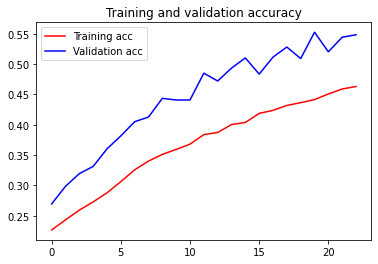

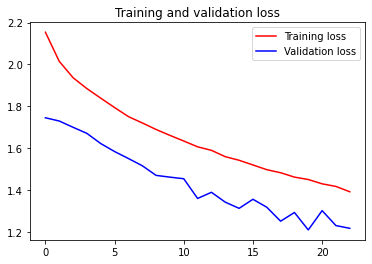

In [ ]:
fine_acc = fine_history.history['accuracy']
fine_val_acc = fine_history.history['val_accuracy']
fine_loss = fine_history.history['loss']
fine_val_loss = fine_history.history['val_loss']

epochs = range(len(fine_acc))

plt.plot(epochs, fine_acc, 'r', label='Training acc')
plt.plot(epochs, fine_val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, fine_loss, 'r', label='Training loss')
plt.plot(epochs, fine_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()




In [ ]:
# evaluate the model on the test set with evaluate() ...
model = tf.keras.models.load_model('/content/gdrive/MyDrive/progetto/modello/keras-facenet/model/fine_tuning_2.h5')
test_loss, test_accuracy = model.evaluate(testing_dataset)
print("Test loss", test_loss)
print("Test accuracy",test_accuracy)

113/113 [==============================] - 1455s 13s/step - loss: 1.4715 - accuracy: 0.4386
Test loss 1.4715052843093872
Test accuracy 0.438562273979187
